#Always learn about the data set before actually working on it.

In [1]:
import os
import numpy as np
import pandas as pd
import os
import tarfile
import hashlib
import time
import pandas
from six.moves import urllib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20



from sklearn.base import BaseEstimator, TransformerMixin


%config IPCompleter.greedy=True

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "../datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = "../datasets/housing/housing.csv"
    return pd.read_csv(csv_path)

In [6]:
housing_data = load_housing_data()

In [7]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


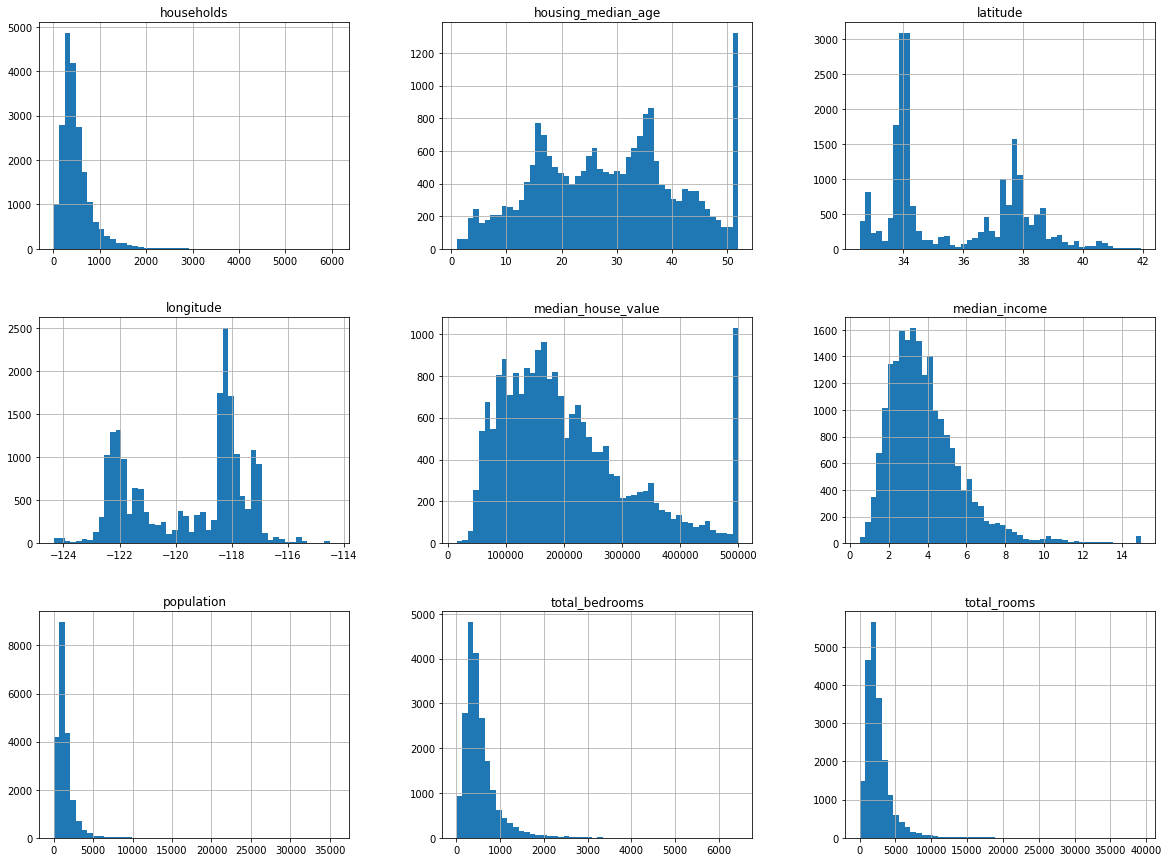

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_data.hist(bins = 50, figsize = (20,15))
plt.show()

In [12]:
import hashlib

def train_test_split(data, test_ratio):
    #np.random.permutation(range) --> Randomly permute a sequence, or return a permuted range.
    np.random.seed(42)
    shuffled_data_indices = np.random.permutation(len(data))
    total_test_data = int(test_ratio * len(data))#---------------->preventing any exception
    test_indices = shuffled_data_indices[:total_test_data]
    training_indices = shuffled_data_indices[total_test_data:]
    return(data.iloc[training_indices], data.iloc[test_indices])

def check_if_test_data(identifier, test_ratio, hash_to_use):
    check = hash_to_use(np.int64(identifier)).digest()[-1]<(test_ratio * 256)
    return check
    
    
def train_test_split_by_identifier(data_with_identifier, test_ratio, identifier_column, hash_to_use):
    indices_to_use_for_hashing = data_with_identifier[identifier_column]
    #pass all the samples one by one using a for loop or some other mechanism
    in_test_set = indices_to_use_for_hashing.apply(lambda id_:check_if_test_data(id_, test_ratio, hash_to_use))
    return(data_with_identifier.loc[~in_test_set], data_with_identifier.loc[in_test_set])
    

In [13]:
train_set, test_set = train_test_split(housing_data, 0.2)
print("Total training samples: ", len(train_set),"+ Total Testing Samples: ",len(test_set))

Total training samples:  16512 + Total Testing Samples:  4128


In [14]:
import hashlib
housing_data_with_id = housing_data.reset_index() #adds an index column ---> not using this column as an identifier
#because we might delete some row in the future that might cause some problem
housing_data_with_id["id"] = housing_data["latitude"] * 1000 + housing_data["longitude"]#-->adding another identifier instead
training_set, testing_set = train_test_split_by_identifier(housing_data_with_id, 0.2, "id", hashlib.md5)
#NB: using latitude and longitude as above because this makes evvery sample pretty much distinct (not tru for this data set
#because this data set's location information isnt quite granular)


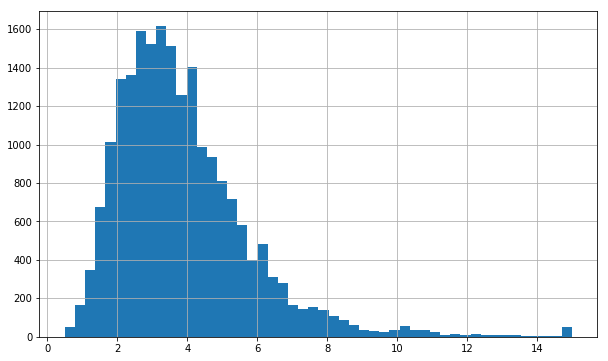

In [15]:

#So far, we performed only random shuffling and sampling by keeping aside the testing data.
#We made sure that the testing data does not appear in the training data when new data is introduced and we have to run the
#model again. However, this random samping is play as long as we have a lot of data available.
#If the dataset is small, there is a chance that we have a sampling bias: the method of collecting samples is biased.
#eg, survey of 1000 workers in a company included 500 males. However, the  population of the workers in the country is 70%
#males. Hence, sampling bias when we use a small amount of data to represent the original population
#Here, male and female are two strata of an attribute which should have been sampled in proportion to the ratio of the
#original population. In this case, the gender was assumed to be the only attribute
#In practice, we have a lot of attributes and we take the most important attribute that affects the label and then do
#stratified sampling of the training and testing data when the available dataset is small to prevent sampling bias

#Hence, SAMPLING BIAS--------------> SKEWED DATA

#Let us perform stratified sampling using the most important attribute(Say) of the dataset, median income
%matplotlib inline
import matplotlib.pyplot as plt
housing_data["median_income"].hist(bins = 50, figsize = (10,6))
plt.show()


In [16]:
#Assume that from the expert knowledge, we know that median income is the most contributing factor for the label in this
#example
#hence, first we need to sample training and testing data in proportion to the whole data set available that is 
#very small to be considered to be a large data set and only after that
#mark the samples such that test samples dont appear in training samples later
#hence use housing_data instead of housing_data_with_id


#first, create a new attribute that places samples into bins according to their income category
#It is important to have a sufficient number of instances from each stratum in the training or testing data.
#Hence, there should not be too many strata

housing_data["income_category_for_stratification"] = np.ceil(housing_data["median_income"]/1.5)
# print(housing_data["income_category_for_stratification"])
housing_data["income_category_for_stratification"].where(housing_data["income_category_for_stratification"]< 5, 5.0, inplace = True)
#
#know what the meaning of in_place is
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

#split.split(housing_data, housing_data["income_category_for_stratification"]) returns two lists containing
#the indices for training and testing data


for training_indices, testing_indices in split.split(housing_data, housing_data["income_category_for_stratification"]):
        stratified_training_data = housing_data.loc[training_indices]
        stratified_testing_data = housing_data.loc[testing_indices]

#now check proportions in all the data set, training data set, and testing data set       
print(housing_data["income_category_for_stratification"].value_counts()/len(housing_data))

print(stratified_training_data["income_category_for_stratification"].value_counts()/len(stratified_training_data))
print(stratified_testing_data["income_category_for_stratification"].value_counts()/len(stratified_testing_data))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_category_for_stratification, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_category_for_stratification, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_category_for_stratification, dtype: float64


In [17]:
for sample in (stratified_training_data, stratified_testing_data):
    sample.drop(["income_category_for_stratification"], axis = 1, inplace = True)

In [18]:
housing_training_data_copy = stratified_training_data.copy()

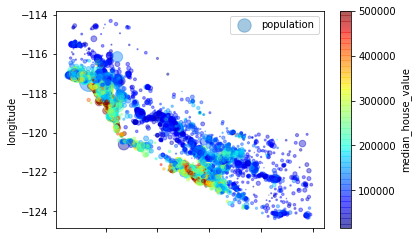

In [19]:
housing_training_data_copy.plot(kind = "scatter", x = "latitude", y = "longitude", alpha = 0.4,
                               s = housing_training_data_copy["population"]/100, label = "population", c = "median_house_value",
                                cmap = plt.get_cmap("jet"),colorbar = True,)
plt.legend()

In [20]:
corr_matrix = housing_training_data_copy.corr()#calculates the correlation coefficient between all the attributes
#lets look at the coefficients between one particular attribute and all others
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe96cff60f0>,
      dtype=object)

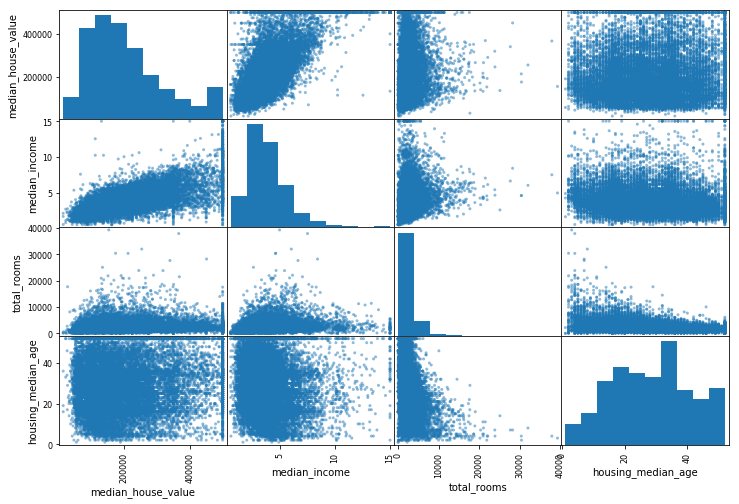

In [21]:
import pandas
from pandas.plotting import scatter_matrix
attributes_to_plot = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_training_data_copy[attributes_to_plot],figsize = (12,8))

In [22]:
def new_attributes_adder(housing_training_data):
    
    housing_training_data["households_per_block"] = housing_training_data["total_rooms"]/housing_training_data["households"]
    housing_training_data["bedroom_to_room_ratio"] = housing_training_data["total_bedrooms"]/housing_training_data["total_rooms"]
    housing_training_data["population_per_household"] = housing_training_data["population"]/housing_training_data["households"]

In [23]:
corr_matrix = housing_training_data_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [24]:
housing_training = stratified_training_data.drop("median_house_value", axis = 1)
housing_training_labels = stratified_training_data["median_house_value"].copy()

In [25]:
housing_training_num = housing_training.drop("ocean_proximity", axis = 1)
numerical_attibutes_names = list(housing_training_num)#--------------->Kada tarika po raixa yo tah

categorical_attributes_names = ["ocean_proximity"]


rooms_id, bedrooms_id, population_id, household_id = [list(housing_training_num.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")] #getting a list of indices for
                    #specific columns

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_combined_attributes = True):
        self.add_combined_attributes = add_combined_attributes
        
    def fit(self, whole_data, y=None):
        return self  # nothing else to do
    
    def transform(self, whole_data, y=None):
        if self.add_combined_attributes:
            rooms_per_household = whole_data[:, rooms_id] / whole_data[:, household_id]
            population_per_household = whole_data[:, population_id] / whole_data[:, household_id]
            bedrooms_per_room = whole_data[:, bedrooms_id] / whole_data[:, rooms_id]
            return np.c_[whole_data, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[whole_data]

attr_adder = CombinedAttributesAdder(add_combined_attributes=False)
housing_num_with_extra_attribs = attr_adder.transform(housing_training_num)

In [26]:

numerical_pipeline = Pipeline([("Imputation",Imputer(strategy = "median")),
                               ("Attributes_addition",CombinedAttributesAdder()),
                               ("Standardization",StandardScaler()),
                              ])

categorical_pipeline = Pipeline([('one_hot_encoder', OneHotEncoder(sparse=False)),
                                ])

   
full_pipeline = ColumnTransformer([("numerical_pipeline",numerical_pipeline,numerical_attibutes_names),
                                                 ("categorical_pipeline",categorical_pipeline, categorical_attributes_names),
                                                 ])
final_prepared_data = full_pipeline.fit_transform(housing_training)
final_prepared_data[:5,:]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [27]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(final_prepared_data, housing_training_labels)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
from sklearn.metrics import mean_squared_error
linreg_predictions = linear_regression.predict(final_prepared_data)
linreg_rmse = mean_squared_error(linreg_predictions, housing_training_labels)
print(linreg_rmse)

4709829587.97112


In [29]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(final_prepared_data, housing_training_labels)
decision_tree_predictions = decision_tree.predict(final_prepared_data)
decision_tree_rmse = mean_squared_error(decision_tree_predictions, housing_training_labels)
print(decision_tree_rmse)

0.0


In [36]:
from sklearn.model_selection import cross_val_score
linear_kfold_scores = cross_val_score(linear_regression, final_prepared_data, housing_training_labels, 
                                      scoring = "neg_mean_squared_error",cv =10)
rmse_scores_linreg_kfold = np.sqrt(-linear_kfold_scores)

decision_tree_kfold_Scores = cross_val_score(decision_tree, final_prepared_data, housing_training_labels, 
                                      scoring = "neg_mean_squared_error",cv =10)
rmse_scores_decision_tree_kfold = np.sqrt(-decision_tree_kfold_Scores)

def display_scores(scores):
    print("Scores: ",scores)
    print("Mean RMSE Score = ",scores.mean())
    print("Standard Deviation of the Scores = ",scores.std())
          
print("For Linear Regression:\n")
display_scores(rmse_scores_linreg_kfold)
          
print("For Decision Tree\n")
          
display_scores(rmse_scores_decision_tree_kfold)

For Linear Regression:

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean RMSE Score =  69052.46136345083
Standard Deviation of the Scores =  2731.674001798348
For Decision Tree

Scores:  [68869.30508644 68442.78881904 69702.21852647 69493.76916702
 71503.07757465 73189.29246054 71676.40975159 71487.3953449
 77375.95849671 68894.27841692]
Mean RMSE Score =  71063.44936442628
Standard Deviation of the Scores =  2565.540542085602


In [33]:
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor()
forest_regressor.fit(final_prepared_data, housing_training_labels)
rf_housing_predictions = forest_regressor.predict(final_prepared_data)
forest_regressor_mse = mean_squared_error(housing_training_labels, rf_housing_predictions)
forest_rmse = np.sqrt(forest_regressor_mse)
print(forest_rmse)

/home/being-aerys/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22389.71026586931


In [35]:
#Now, lets see what the average RMSE is if we do 10-Fold CV instead of this.
forest_kfold_scores = cross_val_score(forest_regressor, final_prepared_data, housing_training_labels,
                                     scoring = "neg_mean_squared_error", cv = 10)
rmse_scores_forest_kfold = np.sqrt(-forest_kfold_scores)

display_scores(rmse_scores_forest_kfold)

Scores:  [51403.73351524 49668.06278086 53340.94214996 54465.69553314
 51950.77575448 54623.73297264 50620.25613238 50040.54454282
 55702.52007298 52593.228816  ]
Mean RMSE Score =  52440.949227049794
Standard Deviation of the Scores =  1960.025890239518


In [ ]:
from sklearn.externals import joblib
joblib.dump(forest_regressor,"forest_regressor_model.pkl")
#if you wanna reload the model later, just use the following line.
#loaded_model = joblib.load("forest_regressor_model.pkl")

In [43]:
from sklearn.model_selection import GridSearchCV
param_grid = [{"n_estimators" : [3,10,30], "max_features" : [2, 4, 6, 8]},
             {"bootstrap" : [False], "n_estimators" : [3, 10],"max_features": [2, 3, 4]},]
forest_regressor = RandomForestRegressor()
gridsearchcv = GridSearchCV(forest_regressor, param_grid, cv = 5, scoring = "neg_mean_squared_error", refit = True)
gridsearchcv.fit(final_prepared_data, housing_training_labels)
print("Hence, the best configuration found was ", gridsearchcv.best_estimator_)
print("Evaluation Scores:\n",gridsearchcv.cv_results_)

Hence, the best configuration found was  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
Evaluation Scores:
 {'split4_test_score': array([-4.19405204e+09, -3.08932533e+09, -2.97502479e+09, -3.74883710e+09,
       -2.80921395e+09, -2.74294428e+09, -3.42668935e+09, -2.89498111e+09,
       -2.63180924e+09, -3.54277009e+09, -2.78238208e+09, -2.66839398e+09,
       -3.89650707e+09, -3.09291733e+09, -3.93469597e+09, -2.73987341e+09,
       -3.63377159e+09, -2.73824922e+09]), 'std_test_score': array([1.50558201e+08, 1.17702721e+08, 1.26002780e+08, 1.69052872e+08,
       1.27323597e+08, 1.45948071e+08, 1.69032061e+08, 1.54544600e+08,
       1.40157275e+08, 1.26093409